## Molecular Dynamics simulations of fluids

In [76]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

### Thermodynamic parameters of simulation

In [77]:
rho    = .88 # density of Argon in natural units
dt     = 0.004 # time step size
T_0    = 1 # temperature
N_cell = 3 # number of unitcells in one direction    


N = 4 * N_cell ** 3 # the total number of particles in the system
L_box = (N / rho) ** (1 / 3) # length of the whole box
L_cell = L_box / N_cell # length of a unitcell

### Initialize positions, velocities and forces

In [78]:
def IC_pos(N_cell, L_cell):
    '''Generate initial positions of LJ fluid'''

    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    
    pos = np.array(pos).reshape((-1, 3))

    return pos * L_cell


def IC_vel(N):
    '''Genreate initial distribution of velocities according to Maxwell-Botlzmann'''

    vel  = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)

    return vel 

**Which quantities change and which remain constant**

- Run the cell below to create initial state of the simulation
Forces, positions and velocities 
- Forces, velocities and positions will be updated as a result of integration of equation of motion (MD simulation)
- We periodically will save velocities and positions for further analysis of thermodynamic data 
- Temperature will change a result of change in velocities but we make sure it remains constant on average by coupling particles to thermostat.

> Number of particles, box size and hence number of interacting pairs remains constant throughout simulation!

In [118]:
pos = IC_pos(N_cell, L_cell)    # Initialize position

vel = IC_vel(N)                 # Initialize velocity

F   = np.zeros((N, N, 3))       # matrix that contains all the forces between i, j particles in 3D

ind = np.triu_indices(N, k=1)   # Indices of upper triangular matrix. Created to avoid acessing force elements via loop

In [80]:
### Study the shapes of the force, pos, vel objects
print('position array', pos.shape)
print('velocity array', vel.shape)
print('force array', F.shape)
print('Indices of relevant portion of force array\n', 
      ind)

position array (108, 3)
velocity array (108, 3)
force array (108, 108, 3)
Indices of relevant portion of force array
 (array([  0,   0,   0, ..., 105, 105, 106]), array([  1,   2,   3, ..., 106, 107, 107]))


### Computation of forces

- Most of the computational heavy lifting in MD simulations goes into evaluation of forces. 

- As the number of particles goes so does the need to evaluate the number of interacting pairs

- In realistic simulations neighbor lists and cutoff distances are used to minimize and keep track of smaller number of particle pairs

In [112]:
def find_force(pos):

    # Compute all unique ij distances
    r_vec = pos[ind[0]] - pos[ind[1]]

    # Use min image criteria for distances
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box

    # Compute r^2
    r_sq = np.sum(r_vec**2, axis=1)

    # Compute forces 
    dUdr = -(48 / r_sq ** 7 - 24 / r_sq ** 4)

    # Compute force maxtirx containing all forces between ij particles dU/dr * dr
    F_vec = dUdr[:, np.newaxis] * r_vec

    F[ind[0], ind[1]] = F_vec

    # Compute total force acting on each particle (i=1,...N) 
    forces = F.sum(axis=0) - F.sum(axis=1)

    # Compute potential energy, pressure and histogram of r^2 pair distances

    U = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)

    P = np.sum(F_vec * r_vec)

    hist = np.histogram(r_sq, bins=30, range=(0, L_box / 2))[0]
    
    return forces, U, P, hist

In [113]:
def time_step(pos, vel, F):
    '''Update velocities, positions and forces after dt time step
    '''

    vel += 0.5 * F * dt
    
    pos = np.mod(pos + vel * dt, L_box)

    F, pot, P, hist = find_force(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)

    return pos, vel, F, pot, kin, P, hist

In [116]:
def simulate(freq_T=10, freq_out=50, nsteps=10000):

    kins, pots, Ps, hists = [], [], [], []
    
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]

    for t in range(nsteps):

        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)

        if t % freq_T == 0:

          vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        
        if t % freq_out == 0:

            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)

    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0)

### Running MD simulation

In [122]:
#------- Simulation parameters ----
rho    = .88 # Density of Argon in natural units
T      = 1   # Temperature
N_cell = 3   # Number of unitcells in one direction    

#------- All else is inferred from simulation params -------
N      = 4 * N_cell ** 3 # the total number of particles in the system
L_box  = (N / rho) ** (1 / 3) # length of the whole box
L_cell =  L_box / N_cell # length of a unitcell
F      = np.zeros((N, N, 3))       
ind    = np.triu_indices(N, k=1) 

#Run simulation
kins, pots, Ps, hist = simulate(freq_T=10, freq_out=50, nsteps=10000)

### Analysis of MD simulation 

/var/folders/3h/w4n54dz57dvbhgvz68gdv0f0f3hkmm/T/ipykernel_93665/1357775899.py:2: RuntimeWarning: invalid value encountered in true_divide
  pair_correlation = hist / (4 * np.pi * rho * r)


Text(0, 0.5, '$g(r)$')

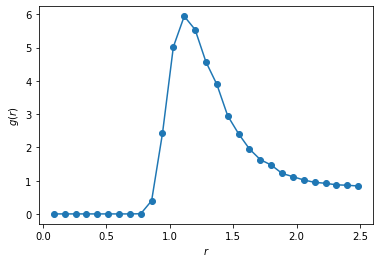

In [123]:
r = np.linspace(0, L_box / 2, 30)
pair_correlation = hist / (4 * np.pi * rho * r)

plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')